In [ ]:
!pip install gpflow
!pip install utils
!pip install cartopy
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)

!pip install shapely --no-binary shapely
!pip install eofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.8/376.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 6.0 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp310-cp310-linux_x86_64.whl size=11102745 sha256=f9e23eaa4159d9dabccbe7524c260ab93d1602067d010071150008925d39ac5f
  Stored in directory: /root/.cache/pip/wheels/30/b0/1a/1c1909e00c76653dc4e2ff48555257c0eb2d1698280c8d9955
Successfully built cartopy
E: Unable to locate package python-cartopy
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
     

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [ ]:
from google.colab import drive


drive.mount('/content/gdrive/', force_remount=True)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob



def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)


def prepare_predictor(data_sets, data_path,time_reindex=True):
    """
    Args:
        data_sets list(str): names of datasets
    """

    # Create training and testing arrays
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    X_all      = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"inputs_{file}.nc"))
        X_all.append(data)
        length_all.append(len(data.time))

    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

def prepare_predictand(data_sets,data_path,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]

    Y_all = []
    length_all = []

    for file in data_sets:
        data = xr.open_dataset(os.path.join(data_path, f"outputs_{file}.nc"))
        Y_all.append(data)
        length_all.append(len(data.time))

    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time').mean('member')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.rename({'lon':'longitude','lat': 'latitude'}).transpose('time','latitude', 'longitude').drop(['quantile'])
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))

    return Y, length_all


def get_rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.latitude))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['latitude', 'longitude'])).data.mean()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()




# Utilities for normalizing the input data
def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

def mean_std_plot(data,color,label,ax):

    mean = data.mean(['latitude','longitude'])
    std  = data.std(['latitude','longitude'])
    yr   = data.time.values

    ax.plot(yr,mean,color=color,label=label,linewidth=4)
    ax.fill_between(yr,mean+std,mean-std,facecolor=color,alpha=0.4)

    return yr, mean

In [ ]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')
test_path  = os.path.join(cwd,'/content/gdrive/MyDrive/climate_emulator_duncan_parris/','train_val1')

make_dir(train_path)
make_dir(test_path)

In [ ]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

In [ ]:

X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


In [ ]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32")
y_test  = np.expand_dims(y_test, -1).astype("float32")

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)
#OUTPUT_DIM =

(753, 96, 144, 1) (86, 96, 144, 1)


In [ ]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [ ]:
latent_dim = 100   # dimensions of the latent space
n_filters  = 64  # number of filters for the convolutional layers
n_neurons  = 32  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernel_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 200

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
import numpy as np

# Encoder
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96, 144, 1)
x = Conv2D(n_filters, kernel_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48, 72, 32)
x = Conv2D(n_filters, kernel_size, activation=activation, strides=2, padding="same")(x) # shape: (24, 36, 32)
x = Conv2D(n_filters, kernel_size, activation=activation, strides=2, padding="same")(x) # shape: (12, 18, 32)
x = Flatten()(x) # shape: (6912,)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,)

z_mean = Dense(latent_dim, name="z_mean")(x) # shape: (2,)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,)

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random

z = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()


# Decoder
decoder_input = Input(shape=(latent_dim,)) # shape: (2,)
cond_input = Input(shape=(X_train.shape[1],)) # shape: (2,)
x = keras.layers.Concatenate(axis=1)([decoder_input, cond_input]) # shape: (4,)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,)
x = Reshape((12, 18, n_filters))(x) # shape: (12, 18, 32)
x = Conv2DTranspose(n_filters, kernel_size, activation=activation, strides=2, padding="same")(x) # shape: (24, 36, 32)
x = Conv2DTranspose(n_filters, kernel_size, activation=activation, strides=2, padding="same")(x) # shape: (48, 72, 32)
x = Conv2DTranspose(n_filters, kernel_size, activation=activation, strides=2, padding="same")(x) # shape: (96, 144, 32)
decoder_output = Conv2DTranspose(1, kernel_size, activation="linear", padding="same")(x) # shape: (96, 144, 1)
decoder_model = Model([decoder_input, cond_input], decoder_output, name="decoder")
decoder_model.summary()


# GAN (Generator + Discriminator)
gan_input = Input(shape=(latent_dim,))
gan_cond_input = Input(shape=(X_train.shape[1],))
generated_image = decoder_model([gan_input, gan_cond_input])

# Freeze the weights of the encoder during GAN training
encoder_model.trainable = False

# Discriminator
discriminator_input = Input(shape=(n_lat, n_lon, 1))
discriminator_features = encoder_model(discriminator_input)
discriminator_output = Dense(1, activation="relu")(discriminator_features)

discriminator_model = Model(discriminator_input, discriminator_output, name="discriminator")
discriminator_model.summary()

# Compile the discriminator
discriminator_model.compile(optimizer=keras.optimizers.legacy.Adam(), loss="binary_crossentropy")

# Combined GAN model (Generator + Discriminator)
gan_output = discriminator_model(generated_image)
gan = Model([gan_input, gan_cond_input], gan_output)
gan.summary()

# Compile the GAN
gan.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy")


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 64)   1088        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 64)   65600       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 64)   65600       ['conv2d_1[0][0]']         

In [ ]:
# Training loop
epochs = 500
batch_size = 32
g = []
d = []

for epoch in range(epochs):
    print("Epoch:", epoch + 1)

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random batch of real samples
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_samples = y_train[idx]
    real_labels = np.ones((batch_size, 1))

    # Generate a batch of fake samples
    latent_samples = np.random.normal(0, 1, (batch_size, latent_dim))
    cond_samples = X_train[idx]
    fake_samples = generator_model.predict([latent_samples, cond_samples])
    fake_labels = np.zeros((batch_size, 1))

    # Train the discriminator
    discriminator_loss_real = discriminator_model.train_on_batch(real_samples, real_labels)
    discriminator_loss_fake = discriminator_model.train_on_batch(fake_samples, fake_labels)
    discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

    # -----------------
    #  Train Generator
    # -----------------

    # Generate a new batch of latent samples and random condition samples
    latent_samples = np.random.normal(0, 1, (batch_size, latent_dim))
    cond_samples = X_train[idx]
    generator_labels = np.ones((batch_size, 1))

    # Train the generator
    generator_loss = gan_model.train_on_batch([latent_samples, cond_samples], generator_labels)



    g.append(generator_loss)
    d.append(discriminator_loss)
    # Print the losses
    print("Discriminator loss:", discriminator_loss)
    print("Generator loss:", generator_loss)
    print()



Epoch: 1


NameError: ignored

In [ ]:
for epoch in range(epochs):
    # ... Rest of the training loop ...

    # Append the losses to the lists
    discriminator_losses.append(discriminator_loss[0])
    generator_losses.append(gan_loss)

# Plotting the losses
plt.plot(range(epochs), discriminator_losses, label='Discriminator Loss')
plt.plot(range(epochs), generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Losses')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])
#print(y_test_pre)
y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values,
                               'latitude': y_test_xr.latitude.values,
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
y_test_pre

<xarray.Dataset>
Dimensions:    (time: 86, latitude: 96, longitude: 144)
Coordinates:
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Data variables:
    tas        (time, latitude, longitude) float32 0.8061 0.8071 ... 0.8036

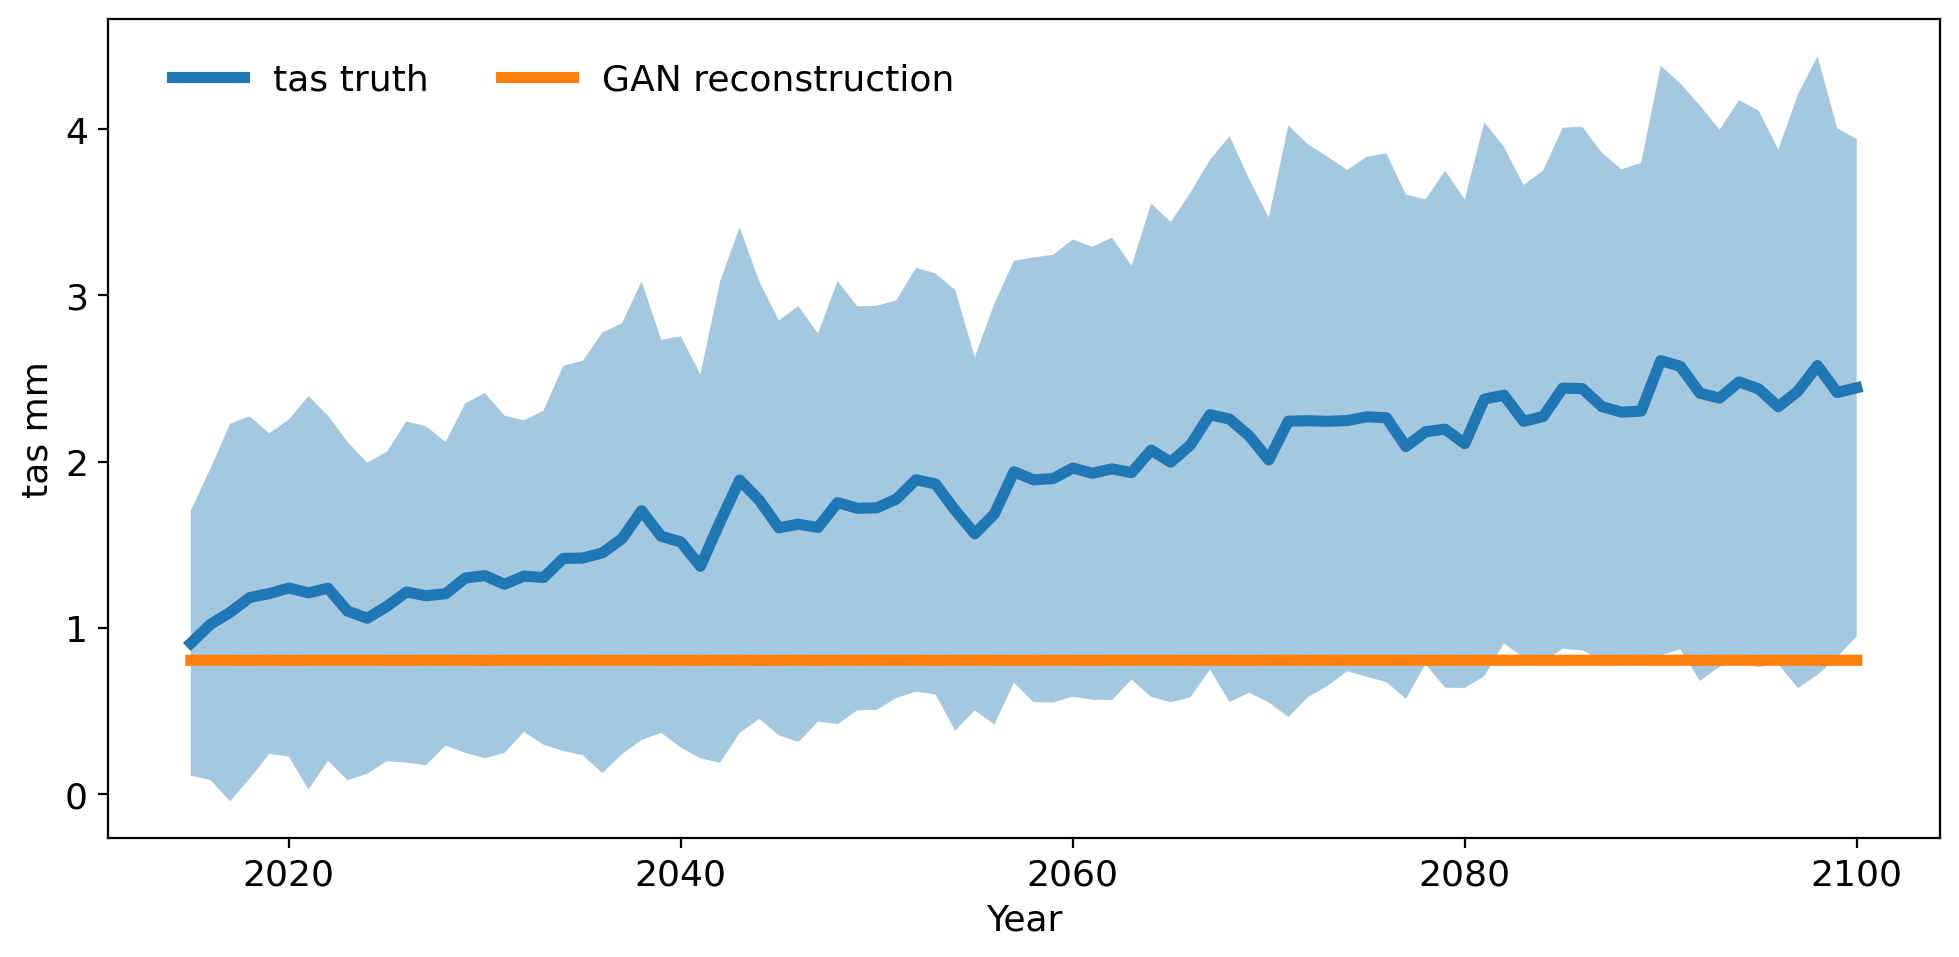

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='GAN reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas mm')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

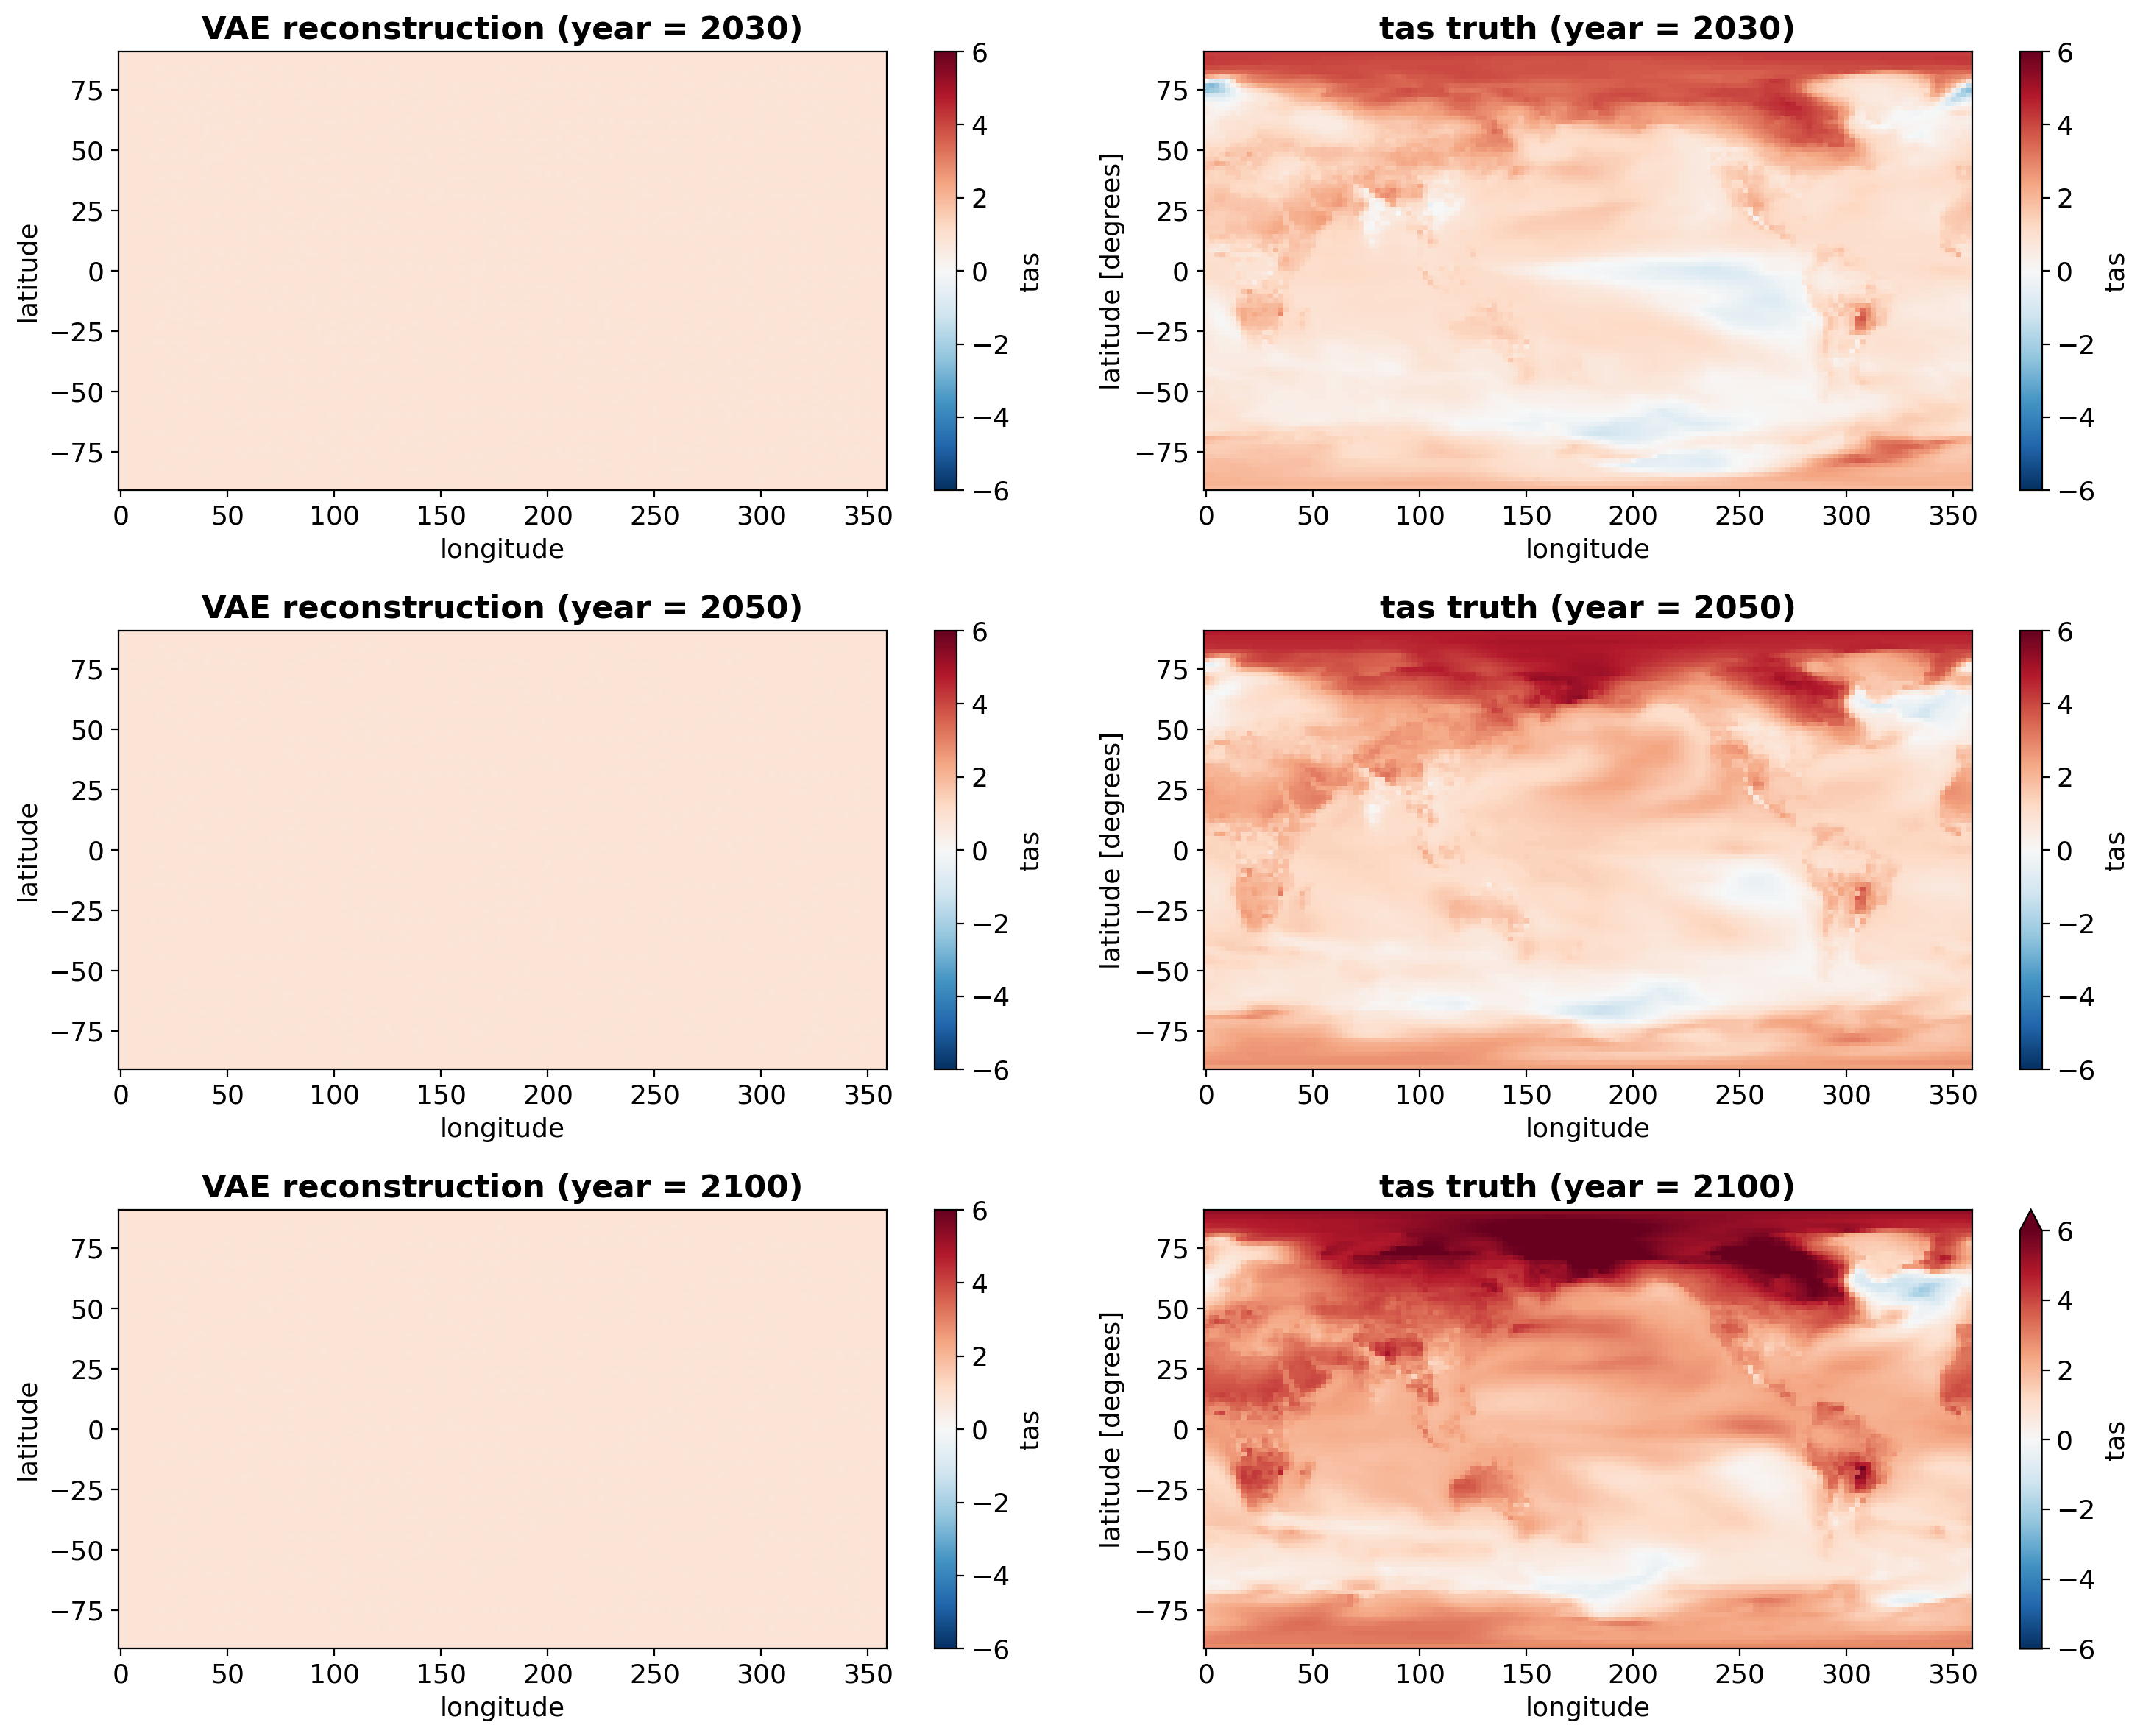

In [ ]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'GAN reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()